# Investigation 01: Spreading Factor Assignment Strategy for Coverage and Capacity Flexible trade-off

### Authors : Luiz (UFJF), Álvaro (UFJF), Jessika (UFRN), Vicente Sousa (UFRN)

**Targets:**
- HOWTO material to download, configure and compile the code;
- HOWTO material to create, run and plot simulations results (including Python scripts);
- Preliminaly analyses of simulation results.


# Getting started


### Download Process

- To download this repository, please, type in the terminal:

```bash
git clone https://github.com/vicentesousa/ns-3-lora-gppcom.git
```

- To go to the code directory, please, type:

```bash
cd ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/
```
- To configure, type:

```bash
CXXFLAGS="-Wall -g -O0" ./waf --build-profile=debug --disable-examples --disable-tests --disable-python configure
```

- To compile, type:

```bash
./waf
```

### Manual installation (optional)

The script **ns3_full_installation.sh** was built to automatically install the code following the three steps:
- Download and solve the dependences;
- Download the ns-3.29 code;
- Download the LoRaWAN ns-3 module (from **https://github.com/signetlabdei/lorawan**) 
- Merge codes from ns-3.29 and LoRaWAN ns-3 module repositories;
- Add ur changes with new ADR codes (from **LoRa-Luiz-vicente** folder).

The script **ns3_full_installation.sh** should be called inside the folder **ns-3-lora-gppcom** (directory of this repository). However, this script has already been executed, with all contents generated and commited into the repository. So, for sake of simplicity, you do not need to repeat its execution every repository clonning.

# Simulation Campaings (creation, run and plot)

Our processo to create, run and plot a simulation campaign is completely based on **yaml** files. In this file, a set of parameters is definied as well as the target parameter to a **parametric evaluation**. Such parametric evaluation allows for the analyses of the LoRaWAN metrics in function of the defined range of the target parameter.

The **yaml** file will be used by to Python functions: the **plotScript.py**, which generates all auxiliary files to run simulations; and **plotScript.py**, which plots the simulation results.

Herein, we provide two campaigns we used to perform the proof-of-concept simulations of our ADR proposal. They are:

- **nDevices** campaign with the following parameters:
   - nDevices (target parameter): 1000, 2000, 3000, 4000, 5000, 6000;
   - radius: 3000

- **radius** campaign with the following parameters:
   - radius (target parameter): 2000, 4000, 6000, 8000, 10000;
   - nDevices: 3000 

**Attention**: maybe you need to specify the **ns3_path** (with our complete path) to run simulation in our local machine.


### Campaign Criation

To configure the simulation campaign and create **ADR_campaign.yaml** file, run the following code. We set a number of 20 simulation runs to get statiscal confidence of performance metrics. 

In [33]:
%%file ADR_campaign.yaml
scenario:
    # Output filename
    filename: CampaignLoraWAN
    # Set location of simulation: local or cluster
    simLocation: local
    # Set campaign scenario: a name of one valid parameter
    #campaign: radius
    campaign: 
        - radius
        - nDevices
    # Number of jobs to run
    jobs: 20
    # Simulation duration (seconds)
    simulationTime: 600
    # Number of end devices to include in the simulation
    nDevices:
        - 3000
        - 1000
        - 2000 
        - 4000
        - 5000
        - 6000 
    # The radius of the area to simulate
    radius: 
        - 3000
        - 2000
        - 4000
        - 6000
        - 8000
        - 10000
    # The period in seconds to be used by periodically transmitting applications
    appPeriodSeconds: 600
    # Whether or not to print various informations
    bPrint: false
    # Fixed seed and run seed (set false for a long simulation campaign)
    fixedSeed: false
    # Algoritmo de ADR: 1 to 5
    Algoritmo: 
        - 1
        - 2
        - 3
        - 4
        - 5
    # Complete path of ns-3 simulator
    ns3_path: ns-allinone-3.29/ns-3.29
    # Script with the main code (inside scratch folder without .cc)
    ns3_script: ADR_code

Overwriting ADR_campaign.yaml


A seguinte função em python foi criada para, de posse do arquivo **yaml**, criar um arquivo **.sh** para rodar a campanha de simulação.  Ao executar esse código no Jupyter Notebook (Shift+Enter), o arquivo **loraScript.py** é gerado.

In [37]:
%%file loraScript.py
from collections import defaultdict
import os
import math
import random
import re
import subprocess
import sys
import argparse
from glob import glob
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
# To install YAML: sudo apt-get install python3-yaml
import yaml

class Simulation:
    def __init__(self, configurations_file):
        #self.email_to = 'sicrano@gmail.com'            
        with open(configurations_file, 'r') as f:
            self.doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
        self.campaign_name = os.path.splitext(configurations_file)[0]
        
        # Read commom parameters
        self.campaign = self.doc['scenario']['campaign']
        self.simLocation = str(doc['scenario']['simLocation'])
        self.simulationTime = self.doc['scenario']['simulationTime']
        self.nDevices = self.doc['scenario']['nDevices'][0]
        self.radius = self.doc['scenario']['radius'][0]
        self.appPeriodSeconds = self.doc['scenario']['appPeriodSeconds']
        self.bPrint = (self.doc['scenario']['bPrint'])
        self.fixedSeed = (self.doc['scenario']['fixedSeed'])
        self.algoritmo = self.doc['scenario']['Algoritmo']
        self.ns3_path = str(self.doc['scenario']['ns3_path'])
        self.ns3_path = os.getcwd() + '/' + self.ns3_path
        self.ns3_script = str(self.doc['scenario']['ns3_script'])
        self.nJobs = int(self.doc['scenario']['jobs'])
        self.filename = str(self.doc['scenario']['filename'])
        self.configurations_file = configurations_file
       
    def runCampaign(self,curCampaign):
        # Configure simulation file in accordance with campaign parameter
        sh_name = self.campaign_name + '_' + self.simLocation + '_' + curCampaign
        print(curCampaign+" campaign written in file: " 'run_%s.sh' % sh_name)
        with open('run_%s.sh' % sh_name, 'w') as f:                    
            if self.simLocation == 'cluster':
              print('To be implemented')
            else:
              outputDir = self.ns3_path+'/results_'+self.simLocation + '_' + curCampaign
              f.write('#!/bin/bash\n')
              f.write('cp -f run_'+sh_name+'.sh'+' '+outputDir+'\n')
              f.write('cp -f '+self.configurations_file+ ' ' +outputDir+'\n')
              f.write("cd '"+self.ns3_path+"'"+"\n")
              f.write('rm -rf '+outputDir+' 2>/dev/null\n')
              f.write('mkdir -p '+outputDir+'\n')
            for iJob in range(0, self.nJobs):
                jobRunSeed = random.randint(1, 23*10**14)
                for iAlg in self.algoritmo:                           
                    for varParam in self.doc['scenario'][curCampaign]:
                      if str(curCampaign) == 'radius':
                          command = (
                          'NS_GLOBAL_VALUE="RngRun='+str(jobRunSeed)+ '" ' +
                          "./waf --run '"+self.ns3_script+
                          " --radius="+varParam+
                          " --nDevices="+self.nDevices+
                          " --simulationTime="+self.simulationTime+
                          " --appPeriodSeconds="+self.appPeriodSeconds+
                          " --print="+self.bPrint+
                          " --fixedSeed="+str(self.fixedSeed)+
                          " --algoritmo="+iAlg+
                          " --filename="+ self.filename +
                          " --outputDir='"+outputDir+"'"
                          "'"
                          )
                      elif str(curCampaign) == 'nDevices':
                          command = (
                          'NS_GLOBAL_VALUE="RngRun='+str(jobRunSeed)+ '" ' +
                          "./waf --run '"+self.ns3_script+ 
                          " --radius="+self.radius+
                          " --nDevices="+varParam+
                          " --simulationTime="+self.simulationTime+
                          " --appPeriodSeconds="+self.appPeriodSeconds+
                          " --print="+self.bPrint+
                          " --fixedSeed="+str(self.fixedSeed)+
                          " --algoritmo="+iAlg+
                          " --filename="+ self.filename +
                          " --outputDir='"+outputDir+"'"
                          "'"
                          )
                      f.write(command+' & wait\n')
                      
parser = argparse.ArgumentParser()
parser.add_argument("-f", "--file", type=str, help='Configuration File')
args = parser.parse_args()

configurations_file = args.file; 
with open(configurations_file, 'r') as f:
    doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
    campaign_name = os.path.splitext(configurations_file)[0]

print('Simulação escolhida: ')
campaign = doc['scenario']['campaign']
print(campaign)
                 
simu = Simulation(configurations_file)

for simC in campaign:
    if str(simC) == 'nDevices' or str(simC) == 'radius':
        simu.runCampaign(simC);
    else:
        print('Invalid simulation campaign: verify the campaign parameter!')

Overwriting loraScript.py


O Script **loraScript.py** recebe um arquivo **yaml** com parâmetro de entrada e gera os segugintes arquivos:

- **run_campanha_local_nDevices.sh**: com as chamadas para as simulações variando o número de dispositivos;
- **run_campanha_local_radius.sh**: com as chamadas para as simulações variando o raio.

Esses dois arquivos **.sh** devem ser chamados em um terminal, chamando as simulações especificas de cada caso.

Abaixo, o script **loraScript.py** é chamado para a **campanha_1.yaml** criada anteriormente.


In [38]:
%run loraScript -f "ADR_campaign.yaml"

Simulação escolhida: 
['radius', 'nDevices']
radius campaign written in file: run_ADR_campaign_local_radius.sh
nDevices campaign written in file: run_ADR_campaign_local_nDevices.sh


Para rodar o código em um terminal, digite:

```python
python3 loraScript.py -f 'ADR_campaign.yaml'
```


Ao rodar o **loraScript.py** com o arquivo **campanha_1.yaml** como parâmetro, os arquivos  **run_all_campanha_1_local_nDevices.sh** e **run_all_campanha_1_local_radius.sh** foram criados. Eles contém a chamada de código para as duas campanhas de simulação especificadas em **campanha_1.yaml**.

O código a seguir executa os dois arquivos **.sh** diretamente deste Jupyter Notebook.

In [18]:
!chmod +x ./run_ADR_campaign_local_radius.sh
!./run_ADR_campaign_local_radius.sh


!chmod +x ./run_ADR_campaign_local_nDevices.sh
!./run_ADR_campaign_local_nDevices.sh

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.448s)
simulation start at: Tue Feb 11 16:47:22 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 913936352, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 16:49:32 2020

Time elapsed: 2.16667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bui

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 17:11:50 2020

Time elapsed: 2.13333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.444s)
simulation start at: Tue Feb 11 17:11:54 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 913936352, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 17:14:03 2020

Time elapsed: 2.15 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf

simulation start at: Tue Feb 11 17:34:17 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 913936352, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 17:36:28 2020

Time elapsed: 2.18333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.398s)
simulation start at: Tue Feb 11 17:36:32 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 913936352, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allin

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.428s)
simulation start at: Tue Feb 11 17:58:42 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 2478757165, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 18:00:50 2020

Time elapsed: 2.13333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bu

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 18:23:14 2020

Time elapsed: 2.15 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.449s)
simulation start at: Tue Feb 11 18:23:17 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 2478757165, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 18:25:28 2020

Time elapsed: 2.18333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf

simulation start at: Tue Feb 11 18:45:59 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2478757165, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 18:48:41 2020

Time elapsed: 2.7 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.437s)
simulation start at: Tue Feb 11 18:48:45 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 2478757165, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allino

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.651s)
simulation start at: Tue Feb 11 19:15:49 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 1715222974, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 19:19:02 2020

Time elapsed: 3.21667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bu

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 19:44:50 2020

Time elapsed: 2.36667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.105s)
simulation start at: Tue Feb 11 19:44:56 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 1715222974, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 19:47:17 2020

Time elapsed: 2.35 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf

simulation start at: Tue Feb 11 20:07:54 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1715222974, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 20:10:02 2020

Time elapsed: 2.13333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.388s)
simulation start at: Tue Feb 11 20:10:06 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1715222974, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-all

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.287s)
simulation start at: Tue Feb 11 20:32:28 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3822412454, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 20:34:36 2020

Time elapsed: 2.13333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bu

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 20:59:51 2020

Time elapsed: 2.48333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.883s)
simulation start at: Tue Feb 11 20:59:56 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3822412454, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 21:02:11 2020

Time elapsed: 2.25 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Wa

simulation start at: Tue Feb 11 21:22:23 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3822412454, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 21:24:34 2020

Time elapsed: 2.18333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.415s)
simulation start at: Tue Feb 11 21:24:38 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3822412454, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-all

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.379s)
simulation start at: Tue Feb 11 21:48:43 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3550997964, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 21:51:33 2020

Time elapsed: 2.83333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bu

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 22:17:24 2020

Time elapsed: 2.46667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (4.517s)
simulation start at: Tue Feb 11 22:17:29 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3550997964, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 22:19:46 2020

Time elapsed: 2.28333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'


simulation start at: Tue Feb 11 22:41:03 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3550997964, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 22:43:20 2020

Time elapsed: 2.28333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.414s)
simulation start at: Tue Feb 11 22:43:24 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3793080295, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-al

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.399s)
simulation start at: Tue Feb 11 23:06:12 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3793080295, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 23:08:21 2020

Time elapsed: 2.15 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 23:30:52 2020

Time elapsed: 2.13333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.401s)
simulation start at: Tue Feb 11 23:30:56 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3793080295, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 23:33:08 2020

Time elapsed: 2.2 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf:

simulation start at: Tue Feb 11 23:53:28 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3824990877, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Tue Feb 11 23:55:44 2020

Time elapsed: 2.26667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.385s)
simulation start at: Tue Feb 11 23:55:48 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3824990877, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-all

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.411s)
simulation start at: Wed Feb 12 00:18:37 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3824990877, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 00:20:47 2020

Time elapsed: 2.16667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bu

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 00:43:33 2020

Time elapsed: 2.15 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.296s)
simulation start at: Wed Feb 12 00:43:37 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3824990877, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 00:45:55 2020

Time elapsed: 2.3 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: L

simulation start at: Wed Feb 12 01:06:28 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 1340355197, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 01:08:37 2020

Time elapsed: 2.15 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.400s)
simulation start at: Wed Feb 12 01:08:41 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 1340355197, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allino

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.409s)
simulation start at: Wed Feb 12 01:31:18 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 1340355197, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 01:33:26 2020

Time elapsed: 2.13333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bu

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 01:56:09 2020

Time elapsed: 2.28333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.414s)
simulation start at: Wed Feb 12 01:56:13 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1340355197, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 01:58:20 2020

Time elapsed: 2.11667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'


simulation start at: Wed Feb 12 02:18:47 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 2928542830, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 02:21:05 2020

Time elapsed: 2.3 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.416s)
simulation start at: Wed Feb 12 02:21:09 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2928542830, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allino

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.332s)
simulation start at: Wed Feb 12 02:43:44 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 2928542830, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 02:45:59 2020

Time elapsed: 2.25 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 03:08:32 2020

Time elapsed: 2.13333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.405s)
simulation start at: Wed Feb 12 03:08:36 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 2928542830, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 03:10:51 2020

Time elapsed: 2.25 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf

simulation start at: Wed Feb 12 03:31:23 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 1861140454, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 03:33:42 2020

Time elapsed: 2.31667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.388s)
simulation start at: Wed Feb 12 03:33:46 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 1861140454, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-all

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.403s)
simulation start at: Wed Feb 12 03:56:38 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 1861140454, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 03:58:57 2020

Time elapsed: 2.31667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bu

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 04:21:28 2020

Time elapsed: 2.13333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.370s)
simulation start at: Wed Feb 12 04:21:32 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1861140454, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 04:23:49 2020

Time elapsed: 2.28333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'

simulation start at: Wed Feb 12 04:44:18 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2464264289, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 04:46:29 2020

Time elapsed: 2.18333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.552s)
simulation start at: Wed Feb 12 04:46:33 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2464264289, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-all

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.307s)
simulation start at: Wed Feb 12 05:09:01 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2464264289, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 05:11:14 2020

Time elapsed: 2.21667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bu

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 05:33:56 2020

Time elapsed: 2.3 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.421s)
simulation start at: Wed Feb 12 05:34:00 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 586484738, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 05:36:13 2020

Time elapsed: 2.21667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: 

simulation start at: Wed Feb 12 05:56:34 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 586484738, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 05:58:50 2020

Time elapsed: 2.26667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.327s)
simulation start at: Wed Feb 12 05:58:53 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 586484738, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-alli

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.386s)
simulation start at: Wed Feb 12 06:21:35 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 586484738, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 06:23:54 2020

Time elapsed: 2.31667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bui

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 06:46:22 2020

Time elapsed: 2.23333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.414s)
simulation start at: Wed Feb 12 06:46:26 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 67995713, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 06:48:38 2020

Time elapsed: 2.2 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: L

simulation start at: Wed Feb 12 07:09:27 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 67995713, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 07:11:45 2020

Time elapsed: 2.3 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.381s)
simulation start at: Wed Feb 12 07:11:49 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 67995713, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.381s)
simulation start at: Wed Feb 12 07:34:38 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 67995713, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 07:36:55 2020

Time elapsed: 2.28333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'buil

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 08:00:58 2020

Time elapsed: 2.55 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.967s)
simulation start at: Wed Feb 12 08:01:05 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 356053234, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 08:03:32 2020

Time elapsed: 2.45 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: L

simulation start at: Wed Feb 12 08:26:32 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 356053234, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 08:28:43 2020

Time elapsed: 2.18333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.567s)
simulation start at: Wed Feb 12 08:28:49 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 356053234, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allin

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.560s)
simulation start at: Wed Feb 12 08:53:06 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 356053234, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 08:55:20 2020

Time elapsed: 2.23333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bui

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 09:18:00 2020

Time elapsed: 2.13333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.283s)
simulation start at: Wed Feb 12 09:18:04 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 168042960, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 09:20:18 2020

Time elapsed: 2.23333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
W

simulation start at: Wed Feb 12 09:41:01 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 168042960, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 09:43:15 2020

Time elapsed: 2.23333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.572s)
simulation start at: Wed Feb 12 09:43:19 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 168042960, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-alli

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.382s)
simulation start at: Wed Feb 12 10:05:48 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 168042960, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 10:07:57 2020

Time elapsed: 2.15 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build'

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 10:30:53 2020

Time elapsed: 2.15 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.437s)
simulation start at: Wed Feb 12 10:30:57 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 1648265640, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 10:33:12 2020

Time elapsed: 2.25 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: L

simulation start at: Wed Feb 12 10:53:41 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 1648265640, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 10:55:51 2020

Time elapsed: 2.16667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.404s)
simulation start at: Wed Feb 12 10:55:55 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 1648265640, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-all

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.274s)
simulation start at: Wed Feb 12 11:18:27 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 2884322519, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 11:20:41 2020

Time elapsed: 2.23333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bu

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 11:43:23 2020

Time elapsed: 2.26667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.275s)
simulation start at: Wed Feb 12 11:43:26 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2884322519, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 11:45:40 2020

Time elapsed: 2.23333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'

simulation start at: Wed Feb 12 12:06:11 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2884322519, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 12:08:21 2020

Time elapsed: 2.16667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.388s)
simulation start at: Wed Feb 12 12:08:24 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2884322519, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-all

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.467s)
simulation start at: Wed Feb 12 12:31:08 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3406376576, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 12:33:24 2020

Time elapsed: 2.26667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bu

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 12:56:07 2020

Time elapsed: 2.16667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.423s)
simulation start at: Wed Feb 12 12:56:11 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3406376576, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 12:58:26 2020

Time elapsed: 2.25 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf

simulation start at: Wed Feb 12 13:19:02 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3406376576, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 13:21:18 2020

Time elapsed: 2.26667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.340s)
simulation start at: Wed Feb 12 13:21:21 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3406376576, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-al

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.415s)
simulation start at: Wed Feb 12 13:44:05 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 1577798194, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 13:46:14 2020

Time elapsed: 2.15 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 14:14:05 2020

Time elapsed: 2.28333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.446s)
simulation start at: Wed Feb 12 14:14:11 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 1577798194, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 14:16:24 2020

Time elapsed: 2.21667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'


simulation start at: Wed Feb 12 14:41:56 2020

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1577798194, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 14:44:19 2020

Time elapsed: 2.38333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.817s)
simulation start at: Wed Feb 12 14:44:26 2020

Running with nDevices = 3000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1577798194, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-all

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.668s)
simulation start at: Wed Feb 12 15:10:27 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3431823765, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 15:12:50 2020

Time elapsed: 2.38333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bu

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 15:37:15 2020

Time elapsed: 2.18333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.481s)
simulation start at: Wed Feb 12 15:37:21 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3431823765, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 15:39:47 2020

Time elapsed: 2.43333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'

simulation start at: Wed Feb 12 16:02:25 2020

Running with nDevices = 3000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3431823765, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 16:04:52 2020

Time elapsed: 2.45 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.558s)
simulation start at: Wed Feb 12 16:04:58 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3431823765, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allino

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.554s)
simulation start at: Wed Feb 12 16:37:20 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 1226052678, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 16:38:19 2020

Time elapsed: 0.983333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json


Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 17:24:17 2020

Time elapsed: 2.28333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.350s)
simulation start at: Wed Feb 12 17:24:21 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 1226052678, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 17:24:34 2020

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/buil

simulation start at: Wed Feb 12 17:59:25 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1226052678, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 18:08:53 2020

Time elapsed: 9.46667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.422s)
simulation start at: Wed Feb 12 18:08:57 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 1469838051, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-a

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.795s)
simulation start at: Wed Feb 12 18:48:54 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 1469838051, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 18:56:05 2020

Time elapsed: 7.18333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 1469838051, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 19:39:08 2020

Time elapsed: 1.01667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.408s)
simulation start at: Wed Feb 12 19:39:12 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 1469838051, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Com

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (6.256s)
simulation start at: Wed Feb 12 20:30:54 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 465222266, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 20:31:11 2020

Time elapsed: 0.283333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 21:16:55 2020

Time elapsed: 9.48333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.696s)
simulation start at: Wed Feb 12 21:17:01 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 465222266, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 21:19:14 2020

Time elapsed: 2.21667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'

'build' finished successfully (5.684s)
simulation start at: Wed Feb 12 21:48:45 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 465222266, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 21:55:09 2020

Time elapsed: 6.4 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.558s)
simulation start at: Wed Feb 12 21:55:16 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 465222266, outputDir = /home/gppc

Computing performance metrics...
simulation finished at: Wed Feb 12 22:31:53 2020

Time elapsed: 0.933333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.598s)
simulation start at: Wed Feb 12 22:32:00 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 1934913958, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 22:35:59 2020

Time elapsed: 3.98333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora20

simulation start at: Wed Feb 12 23:17:58 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 1934913958, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 12 23:18:11 2020

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.458s)
simulation start at: Wed Feb 12 23:18:17 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 1934913958, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.627s)
simulation start at: Thu Feb 13 00:02:38 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1934913958, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 00:04:50 2020

Time elapsed: 2.2 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'buil

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 00:40:49 2020

Time elapsed: 6.3 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.562s)
simulation start at: Thu Feb 13 00:40:55 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 524808050, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 00:50:11 2020

Time elapsed: 9.26667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf

simulation start at: Thu Feb 13 01:17:26 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 524808050, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 01:21:25 2020

Time elapsed: 3.98333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.564s)
simulation start at: Thu Feb 13 01:21:31 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 524808050, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-all

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.512s)
simulation start at: Thu Feb 13 02:03:22 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 524808050, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 02:04:20 2020

Time elapsed: 0.966667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 02:50:44 2020

Time elapsed: 2.15 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (6.124s)
simulation start at: Thu Feb 13 02:50:51 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2224967067, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 02:51:03 2020

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: 

simulation start at: Thu Feb 13 03:26:30 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 2224967067, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 03:35:48 2020

Time elapsed: 9.3 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.598s)
simulation start at: Thu Feb 13 03:35:54 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2224967067, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allin

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.503s)
simulation start at: Thu Feb 13 04:07:15 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 2224967067, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 04:13:32 2020

Time elapsed: 6.28333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 04:50:12 2020

Time elapsed: 0.95 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.559s)
simulation start at: Thu Feb 13 04:50:19 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 209822812, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 04:54:22 2020

Time elapsed: 4.05 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: 

simulation start at: Thu Feb 13 05:35:50 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 209822812, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 05:36:04 2020

Time elapsed: 0.233333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.660s)
simulation start at: Thu Feb 13 05:36:10 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 209822812, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-al

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.665s)
simulation start at: Thu Feb 13 06:20:44 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 2642586260, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 06:22:54 2020

Time elapsed: 2.16667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 06:58:29 2020

Time elapsed: 6.4 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.457s)
simulation start at: Thu Feb 13 06:58:36 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2642586260, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 07:08:13 2020

Time elapsed: 9.61667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Wa

simulation start at: Thu Feb 13 07:35:50 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2642586260, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 07:39:47 2020

Time elapsed: 3.95 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.437s)
simulation start at: Thu Feb 13 07:39:53 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2642586260, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-alli

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.572s)
simulation start at: Thu Feb 13 08:21:59 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 181016495, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 08:22:55 2020

Time elapsed: 0.933333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 09:08:29 2020

Time elapsed: 2.26667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.342s)
simulation start at: Thu Feb 13 09:08:33 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 181016495, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 09:08:46 2020

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build

simulation start at: Thu Feb 13 09:44:06 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 181016495, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 09:53:25 2020

Time elapsed: 9.31667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.399s)
simulation start at: Thu Feb 13 09:53:29 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 181016495, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-all

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.399s)
simulation start at: Thu Feb 13 10:24:26 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 19469162, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 10:30:59 2020

Time elapsed: 6.55 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 11:07:55 2020

Time elapsed: 0.95 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.385s)
simulation start at: Thu Feb 13 11:07:59 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 19469162, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 11:12:07 2020

Time elapsed: 4.13333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf

simulation start at: Thu Feb 13 11:54:02 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 19469162, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 11:54:16 2020

Time elapsed: 0.233333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.411s)
simulation start at: Thu Feb 13 11:54:20 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 19469162, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-alli

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.430s)
simulation start at: Thu Feb 13 12:39:03 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 1704219041, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 12:41:14 2020

Time elapsed: 2.18333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 13:16:19 2020

Time elapsed: 6.25 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.428s)
simulation start at: Thu Feb 13 13:16:23 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 1704219041, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 13:25:41 2020

Time elapsed: 9.3 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: 

simulation start at: Thu Feb 13 13:52:45 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1704219041, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 13:56:50 2020

Time elapsed: 4.08333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.480s)
simulation start at: Thu Feb 13 13:56:54 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1704219041, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-a

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.417s)
simulation start at: Thu Feb 13 14:38:24 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3329993231, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 14:39:21 2020

Time elapsed: 0.95 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bui

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 15:25:04 2020

Time elapsed: 2.23333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.403s)
simulation start at: Thu Feb 13 15:25:08 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3329993231, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 15:25:21 2020

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/buil

simulation start at: Thu Feb 13 16:00:34 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3329993231, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 16:09:52 2020

Time elapsed: 9.3 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.406s)
simulation start at: Thu Feb 13 16:09:56 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 2249361105, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allin

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.448s)
simulation start at: Thu Feb 13 16:40:52 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2249361105, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 16:47:08 2020

Time elapsed: 6.26667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 17:23:28 2020

Time elapsed: 0.933333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.459s)
simulation start at: Thu Feb 13 17:23:32 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2249361105, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 17:27:36 2020

Time elapsed: 4.06667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/buil

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 18:53:22 2020

Time elapsed: 9.25 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.499s)
simulation start at: Thu Feb 13 18:53:26 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 2223177600, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 18:55:34 2020

Time elapsed: 2.13333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
W

simulation start at: Thu Feb 13 19:24:39 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2223177600, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 19:30:52 2020

Time elapsed: 6.21667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.419s)
simulation start at: Thu Feb 13 19:30:56 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2223177600, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-a

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (6.883s)
simulation start at: Thu Feb 13 20:09:44 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 289922318, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 20:14:32 2020

Time elapsed: 4.8 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 21:04:34 2020

Time elapsed: 0.266667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (5.382s)
simulation start at: Thu Feb 13 21:04:40 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 289922318, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 21:05:46 2020

Time elapsed: 1.1 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Wa

simulation start at: Thu Feb 13 21:56:01 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 289922318, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 21:58:34 2020

Time elapsed: 2.55 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (4.138s)
simulation start at: Thu Feb 13 21:58:39 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 289922318, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allino

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.831s)
simulation start at: Thu Feb 13 22:39:46 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 2772719658, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 22:50:25 2020

Time elapsed: 10.65 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bu

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 23:26:34 2020

Time elapsed: 4.56667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.845s)
simulation start at: Thu Feb 13 23:26:39 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 2772719658, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Thu Feb 13 23:34:14 2020

Time elapsed: 7.58333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build

simulation start at: Fri Feb 14 00:15:27 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 2772719658, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 14 00:16:33 2020

Time elapsed: 1.1 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.584s)
simulation start at: Fri Feb 14 00:16:37 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 2772719658, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allin

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.762s)
simulation start at: Fri Feb 14 01:09:29 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2198134125, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 14 01:09:45 2020

Time elapsed: 0.266667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json


Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 14 02:01:22 2020

Time elapsed: 10.7333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (4.021s)
simulation start at: Fri Feb 14 02:01:27 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2198134125, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 14 02:04:01 2020

Time elapsed: 2.56667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build

simulation start at: Fri Feb 14 02:37:09 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 2198134125, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 14 02:44:30 2020

Time elapsed: 7.35 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.726s)
simulation start at: Fri Feb 14 02:44:34 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 2198134125, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-alli

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.608s)
simulation start at: Fri Feb 14 03:26:32 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 1888504368, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 14 03:30:38 2020

Time elapsed: 4.1 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'buil

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 14 04:12:47 2020

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.293s)
simulation start at: Fri Feb 14 04:12:51 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 1888504368, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 14 04:13:46 2020

Time elapsed: 0.916667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
W

simulation start at: Fri Feb 14 04:56:47 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 4088962815, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 14 04:59:02 2020

Time elapsed: 2.25 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.415s)
simulation start at: Fri Feb 14 04:59:06 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 4088962815, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-alli

simulation finished at: Fri Feb 14 05:33:48 2020

Time elapsed: 6.31667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.415s)
simulation start at: Fri Feb 14 05:33:52 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 4088962815, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 14 05:43:03 2020

Time elapsed: 9.18333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.

simulation start at: Fri Feb 14 06:10:07 2020

Running with nDevices = 4000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 4088962815, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 14 06:14:10 2020

Time elapsed: 4.05 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.372s)
simulation start at: Fri Feb 14 06:14:14 2020

Running with nDevices = 5000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 4088962815, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-alli

simulation finished at: Fri Feb 14 06:55:37 2020

Time elapsed: 0.233333 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.279s)
simulation start at: Fri Feb 14 06:55:41 2020

Running with nDevices = 2000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3067159016, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 14 06:56:36 2020

Time elapsed: 0.916667 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-

simulation start at: Fri Feb 14 07:40:21 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3067159016, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 14 07:42:39 2020

Time elapsed: 2.3 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (41.689s)
simulation start at: Fri Feb 14 07:43:23 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3067159016, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-alli

Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.432s)
simulation start at: Fri Feb 14 08:18:31 2020

Running with nDevices = 6000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3067159016, outputDir = /home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Feb 14 08:27:34 2020

Time elapsed: 9.05 minutes
Waf: Entering directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'bui

Os arquivos **.sh** acima chamam as simulações uma a uma, guardando o resultados no seguintes arquivos e pastas:

- **./ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices**: para simulações variando o parâmetros **nDevices**;
    - **campanha_1_local_nDevices.txt**: para resultados de simulação do arquivo **campanha_1.yaml**;
    - **campanha_2_local_nDevices.txt**: para resultados de simulação do arquivo **campanha_2.yaml**;
    

- **./ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius**: para simulações variando o parâmetros **radius**;
    - **campanha_1_local_radius.txt**: para resultados de simulação do arquivo **campanha_1.yaml**;
    - **campanha_2_local_radius.txt**: para resultados de simulação do arquivo **campanha_2.yaml**;
    

Abaixo, o script **loraScript.py** é chamado para criar a outra campanha de simulações criada anteriormente (**campanha_2.yaml**).

# Plotar gráficos 

Para plotar gráficos, chamaremos o mesmo arquivo **yaml** que foi usado para criar as campanhas de simulação. Um novo script chamado **plotScript.py** foi construído para esse fim. Ao executar esse código no Jupyter Notebook (Shift+Enter), o arquivo **plotScript.py** é gerado.

In [43]:
%%file plotScript.py
# Legend
#   RunSeed: 0
#   Seed: 1
#   Algoritmo: 2
#   Radius: 3
#   nDevices: 4
#   appPeriodSeconds:5
#   simulationTime:6
#   PHYTotal: 7
#   PHYSuccessful:8 
#   PHYInterfered: 9
#   PHYNoMoreReceivers: 10
#   PHYUnderSensitivity: 11
#   PHYLostBecauseTX: 12
#   SimulationDuration: 13

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
import scipy.stats as st
import os
import argparse
import yaml
import matplotlib

class openSimulation:
    def __init__(self, configurations_file):
        self.email_to = 'fulano@gmail.com'            
        with open(configurations_file, 'r') as f:
            self.doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
        self.campaign_name = os.path.splitext(configurations_file)[0]
        
        # Read commom parameters
        self.showPlot = True;
        self.plotCI = True;                
        self.campaign = self.doc['scenario']['campaign']
        self.simLocation = str(doc['scenario']['simLocation'])
        self.simulationTime = self.doc['scenario']['simulationTime']
        self.nDevices = self.doc['scenario']['nDevices']
        self.nDevices = list(map(float,self.nDevices))
        self.radius = self.doc['scenario']['radius']
        self.radius = list(map(float,self.radius))
        self.appPeriodSeconds = self.doc['scenario']['appPeriodSeconds']
        self.bPrint = (self.doc['scenario']['bPrint'])
        self.fixedSeed = (self.doc['scenario']['fixedSeed'])
        self.algoritmo = self.doc['scenario']['Algoritmo']
        self.ns3_path = str(self.doc['scenario']['ns3_path'])
        self.ns3_path = os.getcwd() + '/' + self.ns3_path
        self.ns3_script = str(self.doc['scenario']['ns3_script'])
        self.nJobs = int(self.doc['scenario']['jobs'])
        if self.nJobs == 1: # disable the confidence interval
            self.plotCI = False;
        self.filename = str(self.doc['scenario']['filename'])
        
    def doLabel(self, algID):
        # Define labels for plots legends
        if algID == '1':
            return "SF7 (I)"
        elif algID == '2':
            return "Equal Split (II)"
        elif algID == '3':
            return "Unequal Split (III)"
        elif algID == '4':
            return "Product-based (IV)"
        elif algID == '5':
            return "Proposed ADR (V)"
        
        
    def plotCampaign(self,curCampaign, metric):
        # some general configurations
        outputDir = self.ns3_path+'/results_'+self.simLocation + '_' + curCampaign        
        chFile = outputDir+ "/" + self.filename + '.txt'        
        print(chFile)
        simTime = np.loadtxt(chFile, skiprows=1, usecols=(6, ), delimiter=',', unpack=False)                
        resalg = np.loadtxt(chFile, skiprows=1, usecols=(2, ), delimiter=',', unpack=False)
        resradius = np.loadtxt(chFile, skiprows=1, usecols=(3, ), delimiter=',', unpack=False)
        resnDevices = np.loadtxt(chFile, skiprows=1, usecols=(4, ), delimiter=',', unpack=False)
        ressimDur = np.loadtxt(chFile, skiprows=1, usecols=(13, ), delimiter=',', unpack=False)
        resphyTotal = np.loadtxt(chFile, skiprows=1, usecols=(7, ), delimiter=',', unpack=False)
        resphySucc = np.loadtxt(chFile, skiprows=1, usecols=(8, ), delimiter=',', unpack=False)
            
        markersA = cycle(('o', 'v', '^', 's', '>', 'p', '*', 'h', '<', 'H', 'D', 'd'))
        colors = cycle(('b', 'g', 'r', 'c', 'm', 'y', 'k'))                    
        plt.figure()     
        for iAlg in self.algoritmo:
            m_plr, m_plrCI, m_tput, m_tputCI, m_pkt, m_pktCI = [], [], [], [], [], []
            for varParam in sorted(self.doc['scenario'][curCampaign],key=int):
                                
                if str(curCampaign) == 'radius':
                    resalgIndexs = (resalg == int(iAlg)) & (resradius == int(varParam))
                    xlabel='Distância [m]'
                    resxData = sorted(self.radius,key=int)
                elif str(curCampaign) == 'nDevices':
                    resalgIndexs = (resalg == int(iAlg)) & (resnDevices == int(varParam))                    
                    xlabel='Quantidade de Dispositivos'
                    resxData = sorted(self.nDevices,key=int)
                # Plr Evaluation
                label = self.doLabel(iAlg)
                #print(label)
                color=next(colors)
                marker=next(markersA)
                if metric=='PLR':                
                    # Calculate PLR line
                    plr = 100*( resphyTotal[resalgIndexs]-resphySucc[resalgIndexs] ) / resphyTotal[resalgIndexs]
                    m_plr = np.append(m_plr, np.mean(plr))
                    # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                    l, h = st.t.interval(0.95, len(plr)-1, loc=np.mean(plr), scale=st.sem(plr))
                    #l,h = st.norm.interval(0.95, loc=np.mean(plr), scale=st.sem(plr))                                                            
                    m_plrCI = np.append(m_plrCI, h)
                elif metric=='Tput':
                    # TODO
                    # Calculate PLR line
                    tput = 23*( resphySucc[resalgIndexs] ) / float(self.simulationTime)
                    m_tput = np.append(m_tput, np.mean(tput))
                    # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                    l, h = st.t.interval(0.95, len(tput)-1, loc=np.mean(tput), scale=st.sem(tput))
                    #l,h = st.norm.interval(0.95, loc=np.mean(tput), scale=st.sem(tput))                    
                    m_tputCI = np.append(m_tputCI, h)
                elif metric=='Pkt':
                    # TODO
                    # Calculate PLR line
                    pkt = 100 * ( resphySucc[resalgIndexs] ) / resphyTotal[resalgIndexs]
                    m_pkt = np.append(m_pkt, np.mean(pkt))
                    # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                    l, h = st.t.interval(0.95, len(pkt)-1, loc=np.mean(pkt), scale=st.sem(pkt))
                    #l,h = st.norm.interval(0.95, loc=np.mean(pkt), scale=st.sem(pkt))                    
                    m_pktCI = np.append(m_pktCI, h)

                
            # Plot line
            if metric=='PLR':                         
                plt.plot(resxData,m_plr, label=label, marker=marker,color=color)   
                if bool(self.plotCI):
                    plt.errorbar(resxData,m_plr, yerr=(m_plrCI-m_plr), marker=marker,color=color, ls = 'none', lw = 2, capthick = 2)
            elif metric=='Tput':
                # TODO
                plt.plot(resxData,m_tput, label=label, marker=marker,color=color)    
                if bool(self.plotCI):                
                    plt.errorbar(resxData,m_tput, yerr = (m_tputCI-m_tput), marker=marker,color=color, ls = 'none', lw = 2, capthick = 2)
            elif metric=='Pkt':
                # TODO
                plt.plot(resxData,m_pkt, label=label, marker=marker,color=color)    
                if bool(self.plotCI):                
                    plt.errorbar(resxData,m_pkt, yerr = (m_pktCI-m_pkt), marker=marker,color=color, ls = 'none', lw = 2, capthick = 2)
            
        # Plot figure
        params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
        plt.rcParams.update(params)        
        os.makedirs(outputDir+"/ps", exist_ok=True)
        os.makedirs(outputDir+"/png", exist_ok=True)
        
        if metric=='PLR':        
            # Show and save PLR plot
            ylabel="PLR [%]"
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.legend(loc='best', numpoints=1)        
            plt.grid()
            plt.tight_layout()
            if bool(self.plotCI):
                imgfilename = 'PLR_CI_'+curCampaign
            else:
                imgfilename = 'PLR_'+curCampaign
            plt.savefig(outputDir+"/png/"+imgfilename+".png")
            plt.savefig(outputDir+"/ps/"+imgfilename+".eps")
            if bool(self.showPlot):
                plt.show()
            else:
                plt.close()
                
        elif metric=='Tput':
            # TODO
            # Show and save PLR plot
            ylabel="Tput [bps]"
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.legend(loc='best', numpoints=1)        
            plt.grid()
            plt.tight_layout()
            if bool(self.plotCI):
                imgfilename = 'TPUT_CI_'+curCampaign
            else:
                imgfilename = 'TPUT_'+curCampaign    
            plt.savefig(outputDir+"/png/"+imgfilename+".png")
            plt.savefig(outputDir+"/ps/"+imgfilename+".eps")       
            if bool(self.showPlot):
                plt.show()
            else:
                plt.close()

        elif metric=='Pkt':
            # TODO
            # Show and save PLR plot
            ylabel="Pacotes recebidos [%]"
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            #plt.legend(loc='upper left', numpoints=1)        
            plt.legend(loc='best', numpoints=1)        
            plt.grid()
            plt.tight_layout()
            if bool(self.plotCI):
                imgfilename = 'PKT_CI_'+curCampaign
            else:
                imgfilename = 'PKT_'+curCampaign    
            plt.savefig(outputDir+"/png/"+imgfilename+".png")
            plt.savefig(outputDir+"/ps/"+imgfilename+".eps")       
            if bool(self.showPlot):
                plt.show()
            else:
                plt.close()

parser = argparse.ArgumentParser()
parser.add_argument("-f", "--file", type=str, help='Configuration File')
args = parser.parse_args()

configurations_file = args.file; 
with open(configurations_file, 'r') as f:
    doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
    campaign_name = os.path.splitext(configurations_file)[0]

# print(doc)
print('Simulação escolhida: ')
campaign = doc['scenario']['campaign']
print(campaign)
                 
simu = openSimulation(configurations_file)
for iMet in ['PLR', 'Tput', 'Pkt']:
    for simC in campaign:
        if str(simC) == 'nDevices' or str(simC) == 'radius':
            simu.plotCampaign(simC,iMet);
        else:
            print('Invalid simulation campaign: verify the campaign parameter!')


Overwriting plotScript.py


Abaixo, o script **plotScript.py** é chamado para a **campanha_1.yaml** criada e simulada anteriormente. 

Simulação escolhida: 
['radius', 'nDevices']
/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius/CampaignLoraWAN.txt


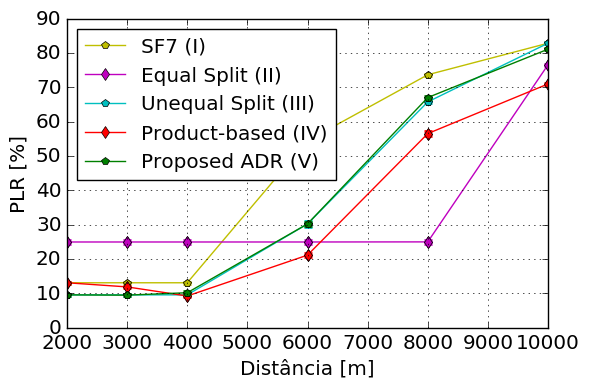

/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices/CampaignLoraWAN.txt


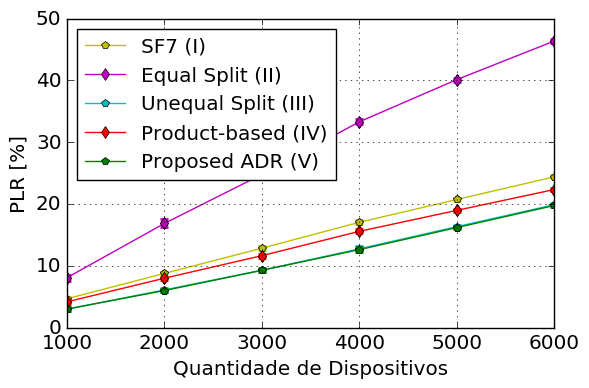

/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius/CampaignLoraWAN.txt


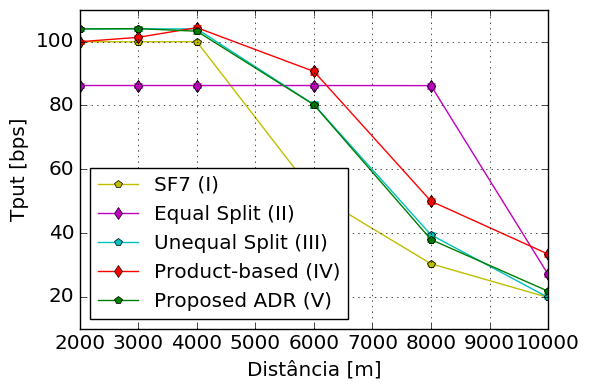

/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices/CampaignLoraWAN.txt


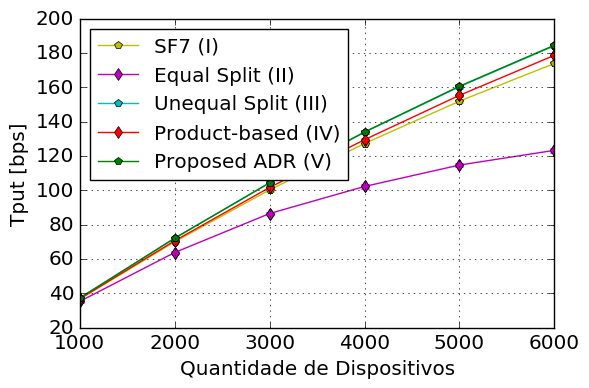

/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius/CampaignLoraWAN.txt


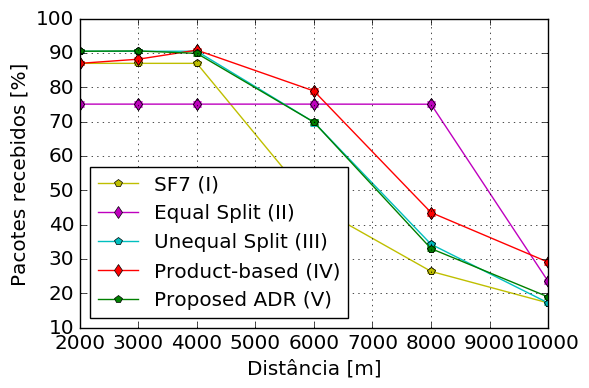

/home/gppcom/lora2020/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices/CampaignLoraWAN.txt


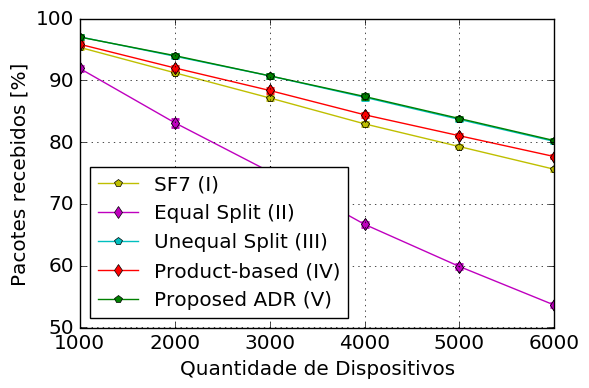

In [42]:
%run plotScript -f "ADR_campaign.yaml"

É possível abservar que o intervalo de confiana já é bem pequeno para 20 jobs.